In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from tqdm import tqdm

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 130  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

# Position generating function
def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

# Vectorized interior point update
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
        (x_new - x_prev)**2 + (x_next - x_new)**2
        - (x_old - x_prev)**2 - (x_next - x_old)**2
    )

    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)

    dS_pot = dt * (
        potential(x_mid_prev_new) + potential(x_mid_next_new)
        - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )

    dS = dS_kin + dS_pot

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# NEW: Endpoint update function
def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
    """
    Vectorised Metropolis update for endpoint (last point) of all paths.
    """
    dt = times[1] - times[0]
    i = paths.shape[1] - 1  # last point

    x_old = paths[:, i]
    x_prev = paths[:, i-1]

    # symmetric proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change (only one neighbor)
    dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)

    # Potential at midpoint between second-to-last and endpoint
    x_mid_old = 0.5 * (x_prev + x_old)
    x_mid_new = 0.5 * (x_prev + x_new)
    dS_pot_mid = dt * (potential(x_mid_new) - potential(x_mid_old))

    # CRITICAL FIX: Also include potential at the endpoint itself (half weight)
    dS_pot_end = 0.5 * dt * (potential(x_new) - potential(x_old))

    dS = dS_kin + dS_pot_mid + dS_pot_end

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# Full sweep function - BETTER optimization
def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop, n_interior_updates=5):
    """
    Do a partial sweep: update only n_interior_updates random interior points
    plus always update the endpoint.
    """
    n_steps = paths.shape[1]

    # Randomly select which interior points to update
    interior_indices = np.random.choice(range(1, n_steps-1), size=n_interior_updates, replace=False)

    acceptances = []
    for i in interior_indices:
        acc = metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop)
        acceptances.append(acc)

    # Always update endpoint
    endpoint_accept = metropolis_endpoint_update_vectorised(
        paths, times, mass, potential, sigma_prop
    )

    return np.mean(acceptances) if acceptances else 0.0, endpoint_accept

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Potentials

In [2]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4
#
# def y_potential(x):
#     return 1000 * ((x-1)**2 + (x+1)**2)

# X-Dimension Sampling

In [6]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

In [7]:
print(paths_x[0])

[ 0.          0.3310282   0.7186307   0.86473171  1.14444447  1.02238975
  0.59949203  0.88037008  1.15858466  1.30513975  1.39313721  1.45588085
  1.64310859  1.49249116  1.2631857   1.24013375  1.31794217  1.01904839
  1.06372192  1.16608588  0.69054465  0.8246626   0.71652694  0.99928086
  1.47168986  1.25960289  1.10912748  0.8803654   0.86780075  0.86180743
  0.87402879  0.77913622  0.61884939  0.35473362  0.49481209  0.2933454
 -0.1116355  -0.04531405  0.40829676  0.2183537   0.16717659  0.34741448
  0.3131988   0.24828507  0.10458623  0.26396076  0.10615113  0.10154925
 -0.09901511  0.04357804 -0.2451516  -0.18315965 -0.16077862 -0.56346481
 -0.47068867 -0.55351943 -0.65046105 -0.65802916 -0.66489935 -1.04718256
 -0.85402053 -0.77637722 -0.70647075 -0.75552651 -0.62685898 -0.45156226
 -0.62449432 -0.36159843 -0.27194679 -0.68639822 -1.02766721 -1.41857548
 -1.7126915  -1.44143159 -1.40600744 -1.33555425 -1.17228913 -1.42937167
 -1.58364451 -1.39698765 -1.36328128 -1.35023753 -1.

In [8]:
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x**2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

# print("\n------ Results ------")
# print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
# print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
# print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
# print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")
#
# # Plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
# plt.plot(x_centres, phi_sq_analytic_x, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
# plt.xlabel('x', fontsize=12)
# plt.ylabel('Probability density', fontsize=12)
# plt.legend(fontsize=11)
# plt.title('Ground State Wavefunction: Path Integral vs Analytic')
#
# plt.tight_layout()
# plt.show()

Thermalizing...


Thermalising:  24%|██▍       | 122/500 [00:00<00:00, 595.91it/s]

Endpoint acceptance ≈ 0.527
Endpoint acceptance ≈ 0.540


Thermalising:  66%|██████▌   | 328/500 [00:00<00:00, 669.44it/s]

Endpoint acceptance ≈ 0.529
Endpoint acceptance ≈ 0.530


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 630.15it/s]


Endpoint acceptance ≈ 0.522

Sampling...


Sampling:   1%|          | 29/5000 [00:00<00:07, 643.35it/s]

Endpoint acceptance ≈ 0.559


Sampling:   3%|▎         | 130/5000 [00:00<00:08, 541.29it/s]

Endpoint acceptance ≈ 0.521


Sampling:   5%|▍         | 227/5000 [00:00<00:07, 619.56it/s]

Endpoint acceptance ≈ 0.582


Sampling:   7%|▋         | 329/5000 [00:00<00:07, 662.03it/s]

Endpoint acceptance ≈ 0.519


Sampling:   9%|▊         | 430/5000 [00:00<00:07, 617.27it/s]

Endpoint acceptance ≈ 0.546


Sampling:  11%|█         | 530/5000 [00:00<00:06, 642.73it/s]

Endpoint acceptance ≈ 0.540


Sampling:  13%|█▎        | 629/5000 [00:00<00:06, 639.10it/s]

Endpoint acceptance ≈ 0.518


Sampling:  15%|█▍        | 729/5000 [00:01<00:06, 624.94it/s]

Endpoint acceptance ≈ 0.544


Sampling:  17%|█▋        | 830/5000 [00:01<00:06, 640.20it/s]

Endpoint acceptance ≈ 0.538


Sampling:  19%|█▊        | 929/5000 [00:01<00:06, 621.96it/s]

Endpoint acceptance ≈ 0.554


Sampling:  21%|██        | 1030/5000 [00:01<00:06, 638.17it/s]

Endpoint acceptance ≈ 0.523


Sampling:  23%|██▎       | 1132/5000 [00:01<00:05, 680.79it/s]

Endpoint acceptance ≈ 0.529


Sampling:  25%|██▍       | 1233/5000 [00:01<00:05, 681.92it/s]

Endpoint acceptance ≈ 0.510


Sampling:  27%|██▋       | 1329/5000 [00:02<00:05, 612.75it/s]

Endpoint acceptance ≈ 0.529


Sampling:  29%|██▊       | 1429/5000 [00:02<00:05, 679.78it/s]

Endpoint acceptance ≈ 0.530


Sampling:  31%|███       | 1531/5000 [00:02<00:05, 647.31it/s]

Endpoint acceptance ≈ 0.535


Sampling:  33%|███▎      | 1631/5000 [00:02<00:05, 614.21it/s]

Endpoint acceptance ≈ 0.489


Sampling:  35%|███▍      | 1731/5000 [00:02<00:05, 635.91it/s]

Endpoint acceptance ≈ 0.526


Sampling:  37%|███▋      | 1830/5000 [00:02<00:04, 663.16it/s]

Endpoint acceptance ≈ 0.513


Sampling:  39%|███▊      | 1929/5000 [00:02<00:04, 701.57it/s]

Endpoint acceptance ≈ 0.557


Sampling:  41%|████      | 2030/5000 [00:03<00:04, 619.43it/s]

Endpoint acceptance ≈ 0.533


Sampling:  43%|████▎     | 2136/5000 [00:03<00:03, 735.05it/s]

Endpoint acceptance ≈ 0.524


Sampling:  45%|████▍     | 2240/5000 [00:03<00:04, 667.72it/s]

Endpoint acceptance ≈ 0.522


Sampling:  47%|████▋     | 2339/5000 [00:03<00:03, 704.92it/s]

Endpoint acceptance ≈ 0.531


Sampling:  49%|████▉     | 2439/5000 [00:03<00:03, 712.61it/s]

Endpoint acceptance ≈ 0.546


Sampling:  51%|█████     | 2537/5000 [00:03<00:03, 671.90it/s]

Endpoint acceptance ≈ 0.529


Sampling:  53%|█████▎    | 2633/5000 [00:04<00:03, 642.02it/s]

Endpoint acceptance ≈ 0.544


Sampling:  55%|█████▍    | 2731/5000 [00:04<00:03, 669.95it/s]

Endpoint acceptance ≈ 0.530


Sampling:  57%|█████▋    | 2828/5000 [00:04<00:03, 654.91it/s]

Endpoint acceptance ≈ 0.529


Sampling:  58%|█████▊    | 2923/5000 [00:04<00:03, 607.07it/s]

Endpoint acceptance ≈ 0.535


Sampling:  61%|██████    | 3027/5000 [00:04<00:02, 714.06it/s]

Endpoint acceptance ≈ 0.519


Sampling:  63%|██████▎   | 3135/5000 [00:04<00:02, 702.40it/s]

Endpoint acceptance ≈ 0.532


Sampling:  65%|██████▍   | 3237/5000 [00:04<00:02, 695.12it/s]

Endpoint acceptance ≈ 0.523


Sampling:  67%|██████▋   | 3335/5000 [00:05<00:02, 692.07it/s]

Endpoint acceptance ≈ 0.562


Sampling:  69%|██████▉   | 3438/5000 [00:05<00:02, 716.79it/s]

Endpoint acceptance ≈ 0.543


Sampling:  71%|███████   | 3534/5000 [00:05<00:02, 675.62it/s]

Endpoint acceptance ≈ 0.500


Sampling:  73%|███████▎  | 3633/5000 [00:05<00:02, 669.78it/s]

Endpoint acceptance ≈ 0.515


Sampling:  75%|███████▍  | 3734/5000 [00:05<00:01, 661.96it/s]

Endpoint acceptance ≈ 0.550


Sampling:  77%|███████▋  | 3831/5000 [00:05<00:01, 683.95it/s]

Endpoint acceptance ≈ 0.525


Sampling:  79%|███████▊  | 3930/5000 [00:06<00:01, 695.95it/s]

Endpoint acceptance ≈ 0.546


Sampling:  81%|████████  | 4038/5000 [00:06<00:01, 664.41it/s]

Endpoint acceptance ≈ 0.514


Sampling:  83%|████████▎ | 4137/5000 [00:06<00:01, 659.86it/s]

Endpoint acceptance ≈ 0.526


Sampling:  85%|████████▍ | 4235/5000 [00:06<00:01, 694.48it/s]

Endpoint acceptance ≈ 0.533


Sampling:  87%|████████▋ | 4337/5000 [00:06<00:00, 667.90it/s]

Endpoint acceptance ≈ 0.531


Sampling:  89%|████████▊ | 4437/5000 [00:06<00:00, 673.59it/s]

Endpoint acceptance ≈ 0.533


Sampling:  91%|█████████ | 4535/5000 [00:06<00:00, 680.03it/s]

Endpoint acceptance ≈ 0.541


Sampling:  93%|█████████▎| 4637/5000 [00:07<00:00, 696.28it/s]

Endpoint acceptance ≈ 0.529


Sampling:  95%|█████████▍| 4738/5000 [00:07<00:00, 665.17it/s]

Endpoint acceptance ≈ 0.541


Sampling:  97%|█████████▋| 4838/5000 [00:07<00:00, 696.52it/s]

Endpoint acceptance ≈ 0.543


Sampling:  99%|█████████▊| 4937/5000 [00:07<00:00, 699.55it/s]

Endpoint acceptance ≈ 0.531


Sampling: 100%|██████████| 5000/5000 [00:07<00:00, 659.88it/s]


# Y-Dimension

Thermalizing...


Thermalising:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_1804\618505141.py:60: RuntimeWarning: overflow encountered in exp
  accept = np.random.rand(len(x_old)) < np.exp(-dS)
Thermalising:  18%|█▊        | 89/500 [00:00<00:00, 501.42it/s]

Endpoint acceptance ≈ 0.306


Thermalising:  39%|███▉      | 196/500 [00:00<00:00, 477.70it/s]

Endpoint acceptance ≈ 0.363


Thermalising:  59%|█████▉    | 294/500 [00:00<00:00, 454.32it/s]

Endpoint acceptance ≈ 0.321


Thermalising:  79%|███████▉  | 396/500 [00:00<00:00, 480.67it/s]

Endpoint acceptance ≈ 0.323


Thermalising:  99%|█████████▉| 495/500 [00:01<00:00, 446.10it/s]

Endpoint acceptance ≈ 0.315


Thermalising: 100%|██████████| 500/500 [00:01<00:00, 466.38it/s]



Sampling...


Sampling:   2%|▏         | 99/5000 [00:00<00:09, 504.64it/s]

Endpoint acceptance ≈ 0.370


Sampling:   4%|▍         | 199/5000 [00:00<00:09, 508.73it/s]

Endpoint acceptance ≈ 0.375


Sampling:   6%|▌         | 298/5000 [00:00<00:09, 482.44it/s]

Endpoint acceptance ≈ 0.322


Sampling:   8%|▊         | 396/5000 [00:00<00:09, 467.85it/s]

Endpoint acceptance ≈ 0.363


Sampling:  10%|▉         | 495/5000 [00:01<00:08, 514.35it/s]

Endpoint acceptance ≈ 0.353


Sampling:  12%|█▏        | 598/5000 [00:01<00:08, 493.71it/s]

Endpoint acceptance ≈ 0.323


Sampling:  14%|█▍        | 695/5000 [00:01<00:09, 476.09it/s]

Endpoint acceptance ≈ 0.326


Sampling:  16%|█▌        | 796/5000 [00:01<00:08, 473.91it/s]

Endpoint acceptance ≈ 0.337


Sampling:  18%|█▊        | 897/5000 [00:01<00:08, 490.14it/s]

Endpoint acceptance ≈ 0.342


Sampling:  20%|█▉        | 998/5000 [00:02<00:07, 502.68it/s]

Endpoint acceptance ≈ 0.345


Sampling:  22%|██▏       | 1100/5000 [00:02<00:08, 478.69it/s]

Endpoint acceptance ≈ 0.337


Sampling:  24%|██▍       | 1198/5000 [00:02<00:07, 502.50it/s]

Endpoint acceptance ≈ 0.351


Sampling:  26%|██▌       | 1297/5000 [00:02<00:08, 462.47it/s]

Endpoint acceptance ≈ 0.371


Sampling:  28%|██▊       | 1396/5000 [00:02<00:07, 494.40it/s]

Endpoint acceptance ≈ 0.355


Sampling:  30%|██▉       | 1496/5000 [00:03<00:07, 489.35it/s]

Endpoint acceptance ≈ 0.337


Sampling:  32%|███▏      | 1593/5000 [00:03<00:07, 463.75it/s]

Endpoint acceptance ≈ 0.349


Sampling:  34%|███▍      | 1698/5000 [00:03<00:06, 491.09it/s]

Endpoint acceptance ≈ 0.316


Sampling:  36%|███▌      | 1800/5000 [00:03<00:06, 507.55it/s]

Endpoint acceptance ≈ 0.333


Sampling:  38%|███▊      | 1898/5000 [00:03<00:06, 484.59it/s]

Endpoint acceptance ≈ 0.365


Sampling:  40%|███▉      | 1998/5000 [00:04<00:06, 500.03it/s]

Endpoint acceptance ≈ 0.350


Sampling:  42%|████▏     | 2102/5000 [00:04<00:06, 436.96it/s]

Endpoint acceptance ≈ 0.326
Endpoint acceptance ≈ 0.344


Sampling:  46%|████▌     | 2297/5000 [00:04<00:05, 473.60it/s]

Endpoint acceptance ≈ 0.348


Sampling:  48%|████▊     | 2394/5000 [00:04<00:05, 440.44it/s]

Endpoint acceptance ≈ 0.330


Sampling:  50%|████▉     | 2489/5000 [00:05<00:05, 450.87it/s]

Endpoint acceptance ≈ 0.349


Sampling:  52%|█████▏    | 2587/5000 [00:05<00:05, 481.56it/s]

Endpoint acceptance ≈ 0.361


Sampling:  54%|█████▍    | 2695/5000 [00:05<00:05, 412.47it/s]

Endpoint acceptance ≈ 0.330


Sampling:  56%|█████▌    | 2792/5000 [00:05<00:04, 451.62it/s]

Endpoint acceptance ≈ 0.342


Sampling:  58%|█████▊    | 2891/5000 [00:06<00:04, 492.07it/s]

Endpoint acceptance ≈ 0.342


Sampling:  60%|█████▉    | 2992/5000 [00:06<00:04, 473.92it/s]

Endpoint acceptance ≈ 0.341


Sampling:  62%|██████▏   | 3097/5000 [00:06<00:03, 496.35it/s]

Endpoint acceptance ≈ 0.353


Sampling:  64%|██████▍   | 3197/5000 [00:06<00:03, 479.22it/s]

Endpoint acceptance ≈ 0.336


Sampling:  66%|██████▌   | 3291/5000 [00:06<00:03, 440.28it/s]

Endpoint acceptance ≈ 0.366


Sampling:  68%|██████▊   | 3387/5000 [00:07<00:03, 449.37it/s]

Endpoint acceptance ≈ 0.329


Sampling:  70%|██████▉   | 3491/5000 [00:07<00:03, 469.20it/s]

Endpoint acceptance ≈ 0.345


Sampling:  72%|███████▏  | 3597/5000 [00:07<00:02, 488.21it/s]

Endpoint acceptance ≈ 0.350


Sampling:  74%|███████▍  | 3696/5000 [00:07<00:02, 470.07it/s]

Endpoint acceptance ≈ 0.325


Sampling:  76%|███████▌  | 3799/5000 [00:08<00:02, 514.88it/s]

Endpoint acceptance ≈ 0.304


Sampling:  78%|███████▊  | 3900/5000 [00:08<00:02, 506.35it/s]

Endpoint acceptance ≈ 0.324


Sampling:  80%|███████▉  | 3998/5000 [00:08<00:02, 417.04it/s]

Endpoint acceptance ≈ 0.373


Sampling:  82%|████████▏ | 4093/5000 [00:08<00:02, 389.80it/s]

Endpoint acceptance ≈ 0.331


Sampling:  84%|████████▍ | 4190/5000 [00:08<00:01, 486.82it/s]

Endpoint acceptance ≈ 0.333


Sampling:  86%|████████▌ | 4297/5000 [00:09<00:01, 513.31it/s]

Endpoint acceptance ≈ 0.339


Sampling:  88%|████████▊ | 4400/5000 [00:09<00:01, 507.26it/s]

Endpoint acceptance ≈ 0.337


Sampling:  90%|████████▉ | 4499/5000 [00:09<00:00, 501.56it/s]

Endpoint acceptance ≈ 0.337


Sampling:  92%|█████████▏| 4592/5000 [00:09<00:00, 452.10it/s]

Endpoint acceptance ≈ 0.331


Sampling:  94%|█████████▍| 4696/5000 [00:09<00:00, 490.26it/s]

Endpoint acceptance ≈ 0.331


Sampling:  96%|█████████▌| 4798/5000 [00:10<00:00, 481.60it/s]

Endpoint acceptance ≈ 0.309


Sampling:  98%|█████████▊| 4893/5000 [00:10<00:00, 494.61it/s]

Endpoint acceptance ≈ 0.343


Sampling: 100%|█████████▉| 4999/5000 [00:10<00:00, 490.51it/s]

Endpoint acceptance ≈ 0.390


Sampling: 100%|██████████| 5000/5000 [00:10<00:00, 471.71it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.1943 (expected ≈ 0.707)
Root mean square: 0.1943 (expected ≈ 0.707)


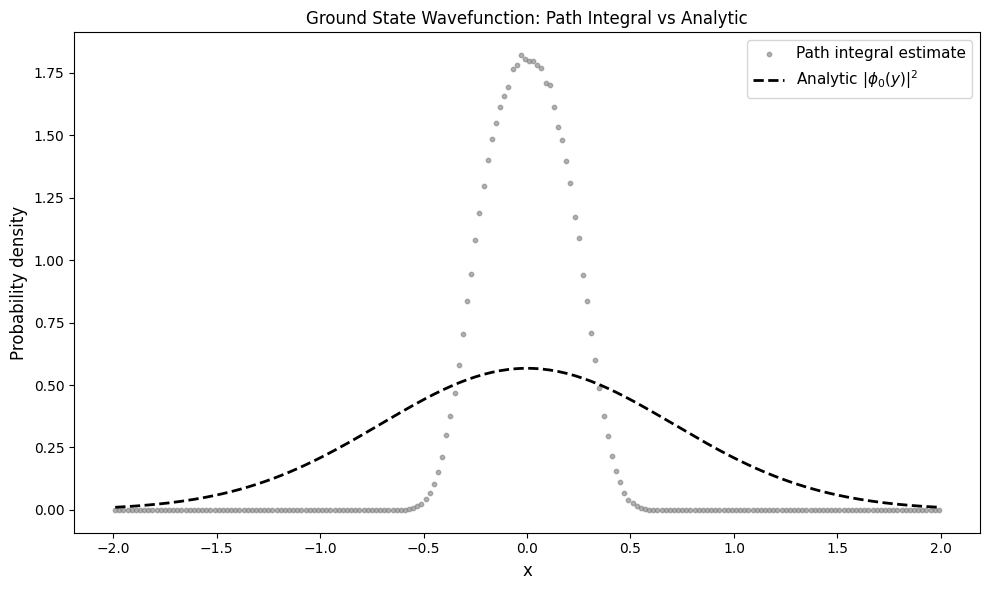

In [19]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_y = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_y.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_y = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_y.append(paths_y[:, -1].copy())

samples_y = np.concatenate(samples_y)

# Compute PDF
y_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_y, bin_edges_y = np.histogram(samples_y, bins=y_bins)

y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

pdf_y = pdf_unnormalised_y / np.sum(pdf_unnormalised_y * dy)

# Analytic PDF
phi_sq_analytic_y = (1 / np.sqrt(np.pi)) * np.exp(-y_centres ** 2)
phi_sq_analytic_y /= np.sum(phi_sq_analytic_y * dy)

# Statistics
mean_square_y = np.mean(samples_y**2)
rms = np.sqrt(mean_square_y)
std = np.std(samples_y)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_y * dy):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_y * dy):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(y_centres, phi_sq_analytic_y, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(y)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

In [20]:
print(len(y_bins))
print(len(pdf_y))
print(len(y_centres))
print(len(samples_y))

print(len(x_bins))
print(len(pdf_x))
print(len(x_centres))
print(len(samples_x))

201
200
200
500000
201
200
200
500000


# 3D extension

In [21]:
# =========================
# 3D Joint Probability Density P(x,y)
# =========================
from scipy.ndimage import gaussian_filter

# 2D histogram
bins = np.linspace(-2, 2, 201)  # 100x100 bins
pdf_xy, x_edges, y_edges = np.histogram2d(samples_x, samples_y, bins=[bins, bins])

dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]

# Normalize so total probability = 1
pdf_xy = pdf_xy / np.sum(pdf_xy * dx * dy)

# Create meshgrid for plotting
x_centres = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centres = 0.5 * (y_edges[1:] + y_edges[:-1])
X, Y = np.meshgrid(x_centres, y_centres)

# Smooth PDF
pdf_xy_smooth = gaussian_filter(pdf_xy, sigma=1)

#extract desired slices
ix0 = np.argmin(np.abs(x_edges[:-1] + dx/2 - 0))  # closest x bin center to 0
iy0 = np.argmin(np.abs(y_edges[:-1] + dy/2 - 0))  # closest y bin center to 0

pdf_xslice = pdf_xy[ix0, :]  # slice along y at x=0
pdf_yslice = pdf_xy[:, iy0]  # slice along x at y=0

pdf_xslice_smooth = pdf_xy_smooth[ix0, :]  # slice along y at x=0
pdf_yslice_smooth = pdf_xy_smooth[:, iy0]  # slice along x at y=0


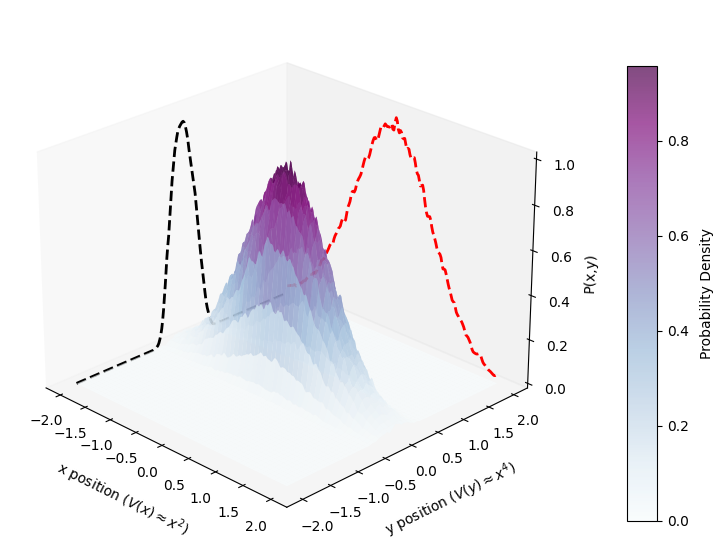

In [27]:
pc_savepath_3D = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\3D_2Potentials.svg"

# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Smoothed surface
surf = ax.plot_surface(X, Y, pdf_xy_smooth.T, cmap='BuPu', edgecolor='none', alpha = 0.7)

ax.view_init(elev=25, azim=-45)
ax.grid(False)

# Left-hand colorbar
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.65])
cbar = fig.colorbar(surf, cax=cbar_ax, orientation='vertical')
cbar.set_label("Probability Density", labelpad=8)

# Back walls for slice projections
x_wall_back = np.min(x_edges)
y_wall_back = np.max(y_centres)

# Slice along y at x=0
ax.plot(np.full_like(y_centres, x_wall_back), y_centres, pdf_xslice_smooth,
        color='black', linewidth=2, linestyle='--', label='x=0 slice')

# Slice along x at y=0
ax.plot(x_centres, np.full_like(x_centres, y_wall_back), pdf_yslice_smooth,
        color='red', linewidth=2, linestyle='--', label='y=0 slice')

# Labels
ax.set_xlabel(r'x position ($V(x) \approx x^2$)', labelpad=10)
ax.set_ylabel(r'y position ($V(y) \approx x^4$)', labelpad=10)
ax.set_zlabel('P(x,y)', labelpad=3, rotation=90)
ax.zaxis.label.set_clip_on(False)
ax.zaxis.set_label_coords(1, 0.5, 0)  # manually position z-label
# Adjust layout manually to show z-label

plt.savefig(pc_savepath_3D, bbox_inches='tight')

plt.show()
